# **Project: BitPredict**

We're going to be building a series of models in an attempt to predict the price of Bitcoin.

In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5e67acdc-115d-50f1-9bf6-71c2d1e62739)


## Get data

Specifically, we're going to get the prices of Bitcoin from 01 October 2013 to 27 July 2021.

Why these dates?

Because 01 October 2013 is when our data source ( [Coindesk](https://www.coindesk.com/price/bitcoin)) started recording the price of Bitcoin.

To get the Bitcoin historical data, I went to the [Coindesk page for Bitcoin prices](https://www.coindesk.com/price/bitcoin), clicked on "all" and then clicked on "Export data" and selected "CSV".

### Importing time series data with pandas

Now we've got some data to work with, let's import it using pandas so we can visualize it.

Because our data is in CSV (comma separated values) format (a very common data format for time series), we'll use the pandas `read_csv()` function.

And because our data has a date component, we'll tell pandas to parse the dates using the `parse_dates` parameter passing it the `name` our of the date column (`"Date"`).

In [ ]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/drive/MyDrive/BitPredict/BTC_USD_2013-10-01_2021-07-27-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2856 entries, 2013-10-01 to 2021-07-27
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2856 non-null   object 
 1   Closing Price (USD)  2856 non-null   float64
 2   24h Open (USD)       2856 non-null   float64
 3   24h High (USD)       2856 non-null   float64
 4   24h Low (USD)        2856 non-null   float64
dtypes: float64(4), object(1)
memory usage: 133.9+ KB


In [ ]:
# How many samples do we have?
len(df)

2856

In our case, we've got the daily prices of Bitcoin, a max of 365 samples per year.

But that doesn't we can't try them with our data.

To simplify, let's remove some of the columns from our data so we're only left with a date index and the closing price.

In [ ]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)" : "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


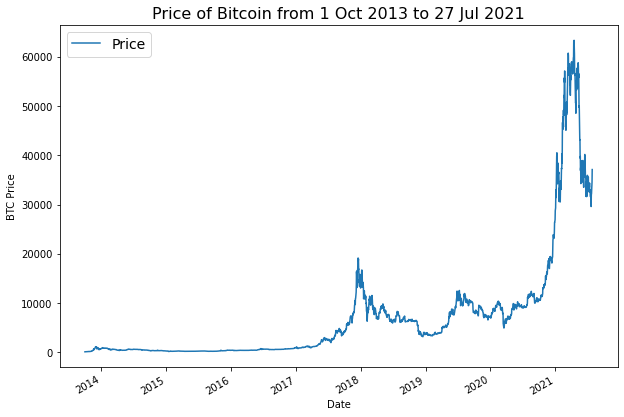

In [ ]:
# let's plot everything we've got
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 27 Jul 2021", fontsize=16)
plt.legend(fontsize=14)

### Importing time series data with Python's CSV module

If your time series data comes in CSV form you don't necessarily have to use pandas.

You can use Python's in-built `csv` module. And if you're working with dates, you might also want to use Python's `datetime`.

Let's see how we can replicate the plot we created before except this time using Python's `csv` and `datetime` modules.

In [ ]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/drive/MyDrive/BitPredict/BTC_USD_2013-10-01_2021-07-27-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0, 0.5, 'BTC Price')

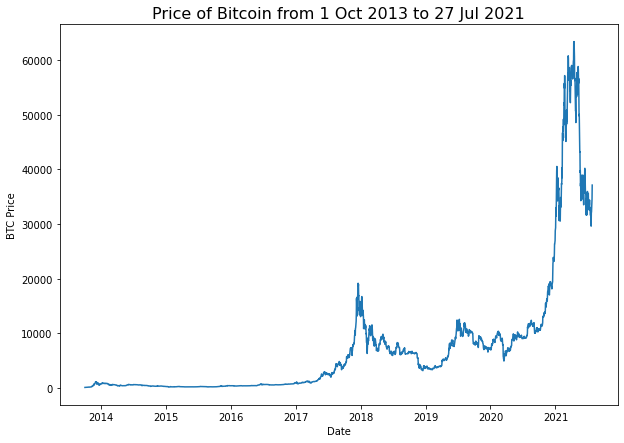

In [ ]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 27 Jul 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price")

## Format Data Part 1: Creatining train and test sets for time series data

### Create train & test sets for time series

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices))

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2284, 572, 2284, 572)

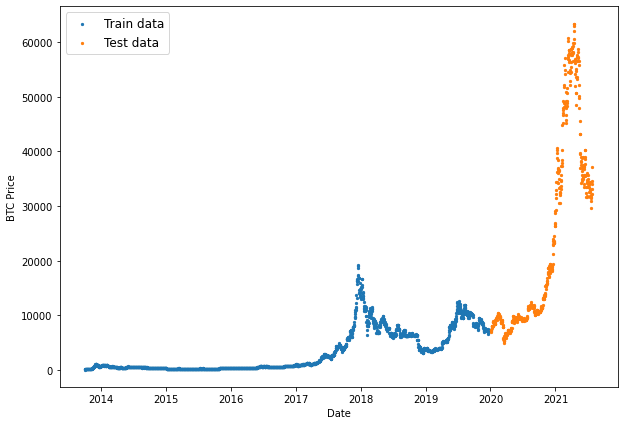

In [ ]:
# Plot correctly made splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=12)
plt.show()

### Create a plotting function

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

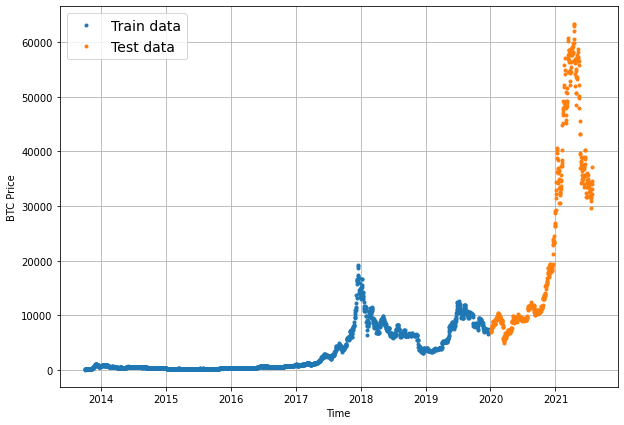

In [ ]:
# Try out our plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Model 0: Naïve forecast (baseline)

One of the most common baseline models for time series forecasting, the naïve model (also called the naïve forecast), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

In [ ]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([6955.48757967, 7291.21950532, 7337.63667014, 7347.43326444,
        7713.86075365, 8039.60370082, 8067.60636906, 7808.70136382,
        8087.45288524, 8078.99353199]),
 array([31596.29438325, 31640.91812684, 31537.80518997, 30940.28728402,
        29608.59725347, 32014.43603389, 32203.3656377 , 33117.75146222,
        34014.618359  , 34574.67066093]))

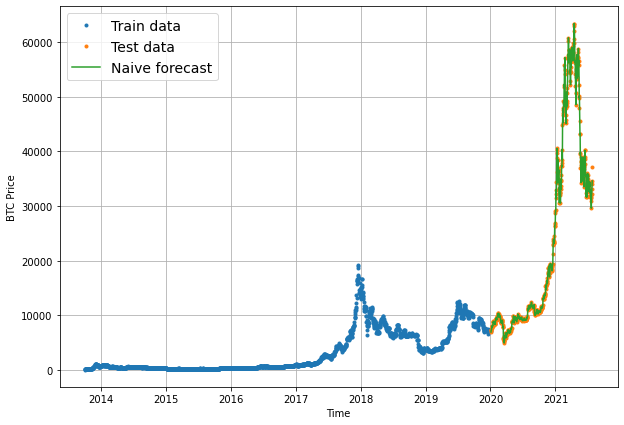

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10,7))
plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")
plot_time_series(X_test[1:], naive_forecast,format="-", label="Naive forecast")

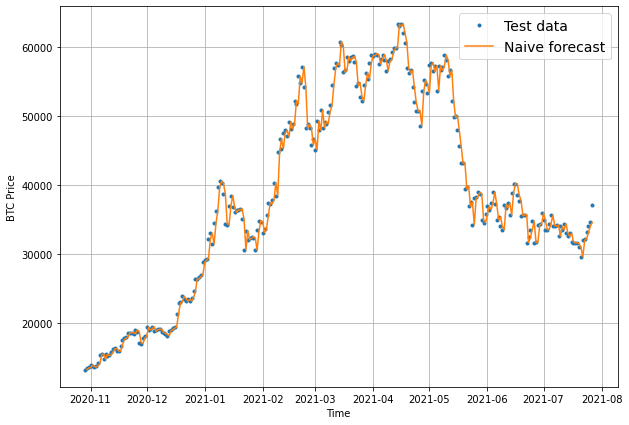

In [ ]:
# Let's zoom in to take a better look
plt.figure(figsize=(10,7))
offset = 300 # offset the values by 300 timesteps
plot_time_series(X_test, y_test, start=offset, label="Test data")
plot_time_series(X_test[1:], naive_forecast, format="-", start=offset, label="Naive forecast")

When we zoom in we see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

## Evaluating a time series model

### Scale-dependent errors

These are metrics which can be used to compare time series values and forecasts that are on the same scale.

For example, Bitcoin historical prices in USD veresus Bitcoin forecast values in USD.

| Metric | Details | Code |
| ----- | ----- | ----- |
| **MAE** (mean absolute error) | Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median. | [`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError) |
| **RMSE** (root mean square error) | Forecasts which minimise the RMSE lead to forecasts of the mean. | `tf.sqrt(`[`tf.keras.metrics.mean_square_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`|

### Percentage errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MAPE** (mean absolute percentage error) | Most commonly used percentage error. May explode (not work) if `y=0`. | [`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE) | 
| **sMAPE** (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions. | Custom implementation |

### Scaled errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MASE** (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE. | See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |

Since we're going to be evaluing a lot of models, let's write a function to help us calculate evaluation metrics on their forecasts.

In [ ]:
# Let's get TensorFlow! 
import tensorflow as tf

And since TensorFlow doesn't have a ready made version of MASE (mean aboslute scaled error), how about we create our own?

We'll take inspiration from [sktime's](https://github.com/alan-turing-institute/sktime) (Scikit-Learn for time series) `mase_loss()` function which calculates the MASE.

In [ ]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [ ]:
# Let's put each of our different evaluation metrics together into a function
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae" : mae.numpy(),
          "mse" : mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 689.12286,
 'mape': 2.6885478,
 'mase': 0.99910104,
 'mse': 1442619.8,
 'rmse': 1201.0911}

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$689 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [ ]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

23124.84541221354

## Format Data Part 2: Windowing dataset

In [ ]:
# We'll start with the default horizon size of 1 and a window size of 7
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [ ]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = tf.expand_dims(np.arange(window_size+horizon), axis=0)
  print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels 

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

Window step:
 [[0 1 2 3 4 5 6 7]]
Window indexes:
 (<tf.Tensor: shape=(3, 8), dtype=int64, numpy=
array([[0, 1, 2, 3, 4, 5, 6, 7],
       [1, 2, 3, 4, 5, 6, 7, 8],
       [2, 3, 4, 5, 6, 7, 8, 9]])>, <tf.Tensor: shape=(3, 8), dtype=int64, numpy=
array([[2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853],
       [2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854],
       [2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855]])>, TensorShape([2849, 8]))


(2849, 2849)

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [31640.91812684 31537.80518997 30940.28728402 29608.59725347
 32014.43603389 32203.3656377  33117.75146222] -> Label: [34014.618359]
Window: [31537.80518997 30940.28728402 29608.59725347 32014.43603389
 32203.3656377  33117.75146222 34014.618359  ] -> Label: [34574.67066093]
Window: [30940.28728402 29608.59725347 32014.43603389 32203.3656377
 33117.75146222 34014.618359   34574.67066093] -> Label: [37114.29662368]


## Turning windows into training and test sets

In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2279, 570, 2279, 570)

In [ ]:
# How do the first 5 samples of the training windows and labels looks?
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint

Because our model's performance will fluctuate from experiment to experiment, we'll want to make sure we're comparing apples to apples.

What I mean by this is in order for a fair comparison, we want to compare each model's best performance against each model's best performance.

For example, if `model_1` performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

And the same goes for each of our other models: compare the best against the best.

To take of this, we'll implement a `ModelCheckpoint` callback.

Because we're going to be running multiple experiments, it makes sense to keep track of them by saving models to file under different names.

To do this, we'll write a small function to create a ModelCheckpoint callback which saves a model to specified filename.

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0,  # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1: Dense model (window = 7, horizon = 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                               
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            batch_size=128,
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 1s 10ms/step - loss: 792.5008 - mae: 792.5008 - val_loss: 2629.8237 - val_mae: 2629.8237
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 231.1119 - mae: 231.1119 - val_loss: 1198.4750 - val_mae: 1198.4750
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 182.8783 - mae: 182.8783 - val_loss: 1131.0531 - val_mae: 1131.0531
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 168.5715 - mae: 168.5715 - val_loss: 1109.4424 - val_mae: 1109.4424
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 164.4695 - mae: 164.4695 - val_loss: 1135.3381 - val_mae: 1135.338

In [ ]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 821.3956 - mae: 821.3956


[821.3955688476562, 821.3955688476562]

In [ ]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 693.1340 - mae: 693.1340


[693.1339721679688, 693.1339721679688]

## Making forecasts with a model (on the test dataset)

In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(570, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([7233.737 , 7338.271 , 7368.843 , 7670.3936, 8032.573 , 8096.269 ,
        7877.4736, 8070.7837, 8086.428 , 8149.4155], dtype=float32)>)

With these outputs, our model isn't forecasting yet. It's only making predictions on the test dataset. Forecasting would involve a model making predictions into the future, however, the test dataset is only a pseudofuture.

In [ ]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': 693.134,
 'mape': 2.7219105,
 'mase': 1.0032718,
 'mse': 1466880.6,
 'rmse': 1211.1484}

In [ ]:
naive_results

{'mae': 689.12286,
 'mape': 2.6885478,
 'mase': 0.99910104,
 'mse': 1442619.8,
 'rmse': 1201.0911}

It looks like our naïve model beats our first deep model on nearly every metric.

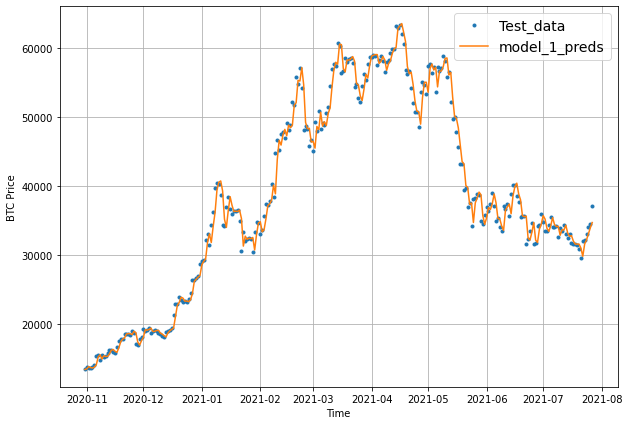

In [ ]:
# Vizualize results
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

What's wrong with these predictions?

As mentioned before, they're on the test dataset. So they're not actual forecasts.

With our current model setup, how do you think we'd make forecasts for the future?

Have a think about it for now, we'll cover this later on.

## Model 2: Dense (window = 30, horizon = 1)

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30

In [ ]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, 
                                         window_size=WINDOW_SIZE, 
                                         horizon=HORIZON)
len(full_windows), len(full_labels)

Window step:
 [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30]]
Window indexes:
 (<tf.Tensor: shape=(3, 31), dtype=int64, numpy=
array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
       [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]])>, <tf.Tensor: shape=(3, 31), dtype=int64, numpy=
array([[2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833,
        2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844,
        2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853],
       [2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834,
        2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 28

(2826, 2826)

In [ ]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2260, 566, 2260, 566)

In [ ]:
# let's construct model_2
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)                               
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [ ]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 930.0156


930.0155639648438

In [ ]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 735.7648


735.7647705078125

In [ ]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [ ]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 735.7648,
 'mape': 2.895423,
 'mase': 1.0594584,
 'mse': 1579209.2,
 'rmse': 1256.6659}

It looks like `model_2` performs worse than the naïve model as well as `model_1`!

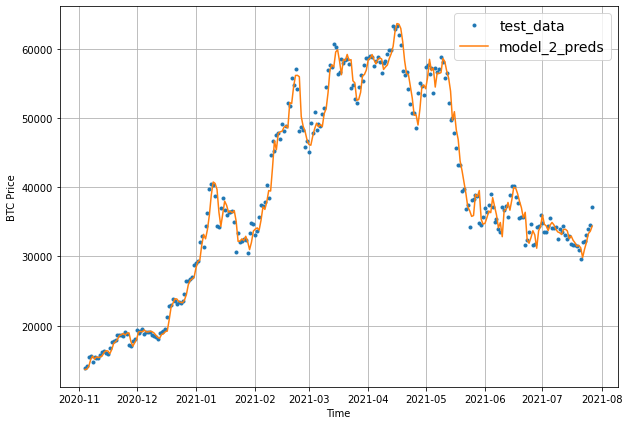

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)

In [ ]:
# Prepare data
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

Window step:
 [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36]]
Window indexes:
 (<tf.Tensor: shape=(3, 37), dtype=int64, numpy=
array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37],
       [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]])>, <tf.Tensor: shape=(3, 37), dtype=int64, numpy=
array([[2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827,
        2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838,
        2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849,
        2850,

(2256, 564, 2256, 564)

In [ ]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [ ]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1615.7169


1615.7169189453125

In [ ]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1515.7319


1515.73193359375

In [ ]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[7182.8506, 7177.9346, 7127.6597, 7270.9087, 7238.343 , 7176.2876,
        7135.4707],
       [7268.477 , 7327.588 , 7222.7603, 7261.305 , 7381.947 , 7400.272 ,
        7112.7593],
       [7336.0166, 7377.8335, 7371.6294, 7467.0034, 7565.895 , 7479.987 ,
        7291.234 ],
       [7537.5435, 7631.24  , 7577.365 , 7624.3486, 7544.9634, 7582.576 ,
        7485.158 ],
       [7931.732 , 7950.4263, 7873.1313, 7999.748 , 7923.8735, 7926.31  ,
        7712.877 ]], dtype=float32)>

In [ ]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)

In [ ]:
model_3_results["mae"].shape

(564,)

## Make our evaluation function work for larger horizons

In [ ]:
# let's adjust our evaluate_preds() function to work with multiple shapes of data.
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1515.732,
 'mape': 5.8980827,
 'mase': 2.1957178,
 'mse': 6989425.5,
 'rmse': 1735.8684}

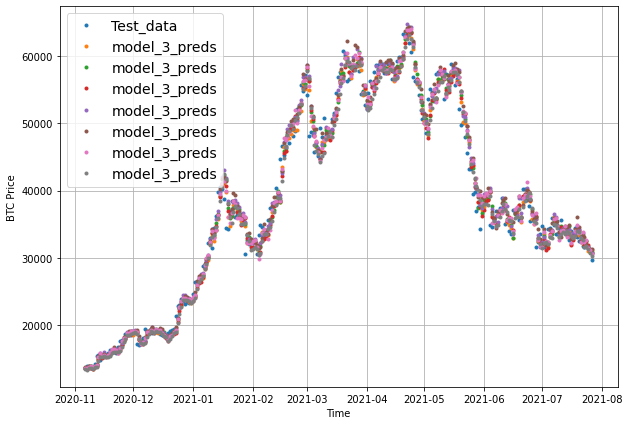

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

In [ ]:
model_3_preds.shape

TensorShape([564, 7])

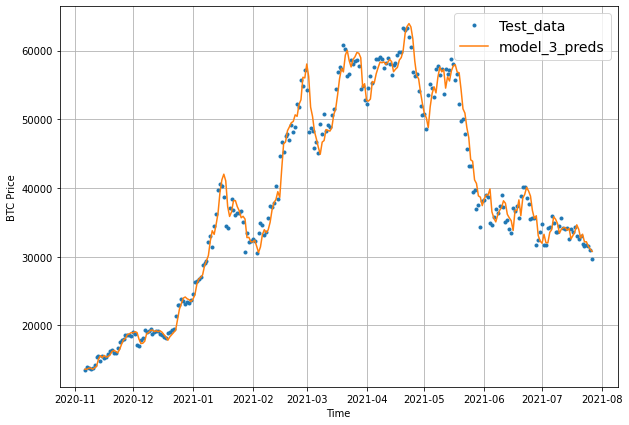

In [ ]:
# Aggregating the predictions
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

## Which of our models is performing best so far?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naïve model to see which model is performing the best so far.

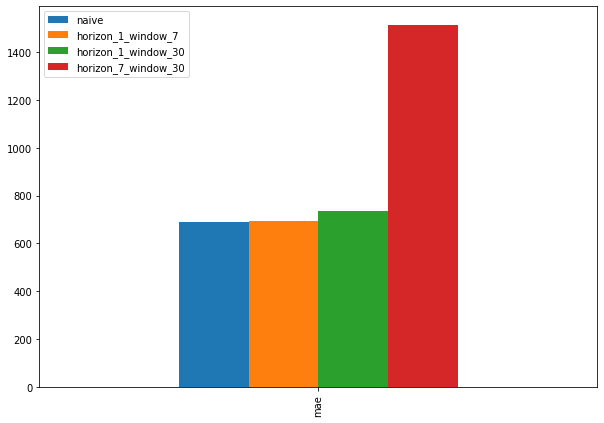

In [ ]:
pd.DataFrame({"naive" : naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10,7), kind="bar")

Our naïve model is performing best (it's very hard to beat a naïve model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.

Because of this, let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

## Model 4: Conv1D

This time, we'll be using a Conv1D model. Because Conv1D models can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is called a many to one problem).

In [ ]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

Window step:
 [[0 1 2 3 4 5 6 7]]
Window indexes:
 (<tf.Tensor: shape=(3, 8), dtype=int64, numpy=
array([[0, 1, 2, 3, 4, 5, 6, 7],
       [1, 2, 3, 4, 5, 6, 7, 8],
       [2, 3, 4, 5, 6, 7, 8, 9]])>, <tf.Tensor: shape=(3, 8), dtype=int64, numpy=
array([[2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853],
       [2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854],
       [2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855]])>, TensorShape([2849, 8]))


(2279, 570, 2279, 570)

Now, since we're going to be using Conv1D layers, we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim).`

Right now, our data has the timesteps dimension ready but we'll have to adjust it to have the `input_dim` dimension.

In [ ]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

To fix this, we could adjust the shape of all of our train_windows or we could use a `tf.keras.layers.Lamdba` (called a Lambda layer) to do this for us in our model.

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [ ]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)                              
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
# What does the Lambda layer look like in a summary?
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1, 7)              0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 128)            4608      
_________________________________________________________________
dense_6 (Dense)              (None, 1, 1)              129       
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 697.6920


697.6920166015625

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([7216.255 , 7332.8022, 7368.1646, 7662.0996, 8018.779 , 8131.7646,
       7917.652 , 8070.447 , 8122.298 , 8166.993 ], dtype=float32)>

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 697.6921,
 'mape': 2.7404385,
 'mase': 1.0098695,
 'mse': 1478873.8,
 'rmse': 1216.0895}

## Model 5: RNN (LSTM)

Once again, one of the most important steps for the LSTM model will be getting our data into the right shape.

The `tf.keras.layers.LSTM()` layer takes a tensor with `[batch, timesteps, feature]` dimensions.

To fix this, just like we did with the `Conv1D` model, we can use a `tf.keras.layers.Lambda()` layer to adjust the shape of our input tensors to the LSTM layer.

In [ ]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)  # expand input dimension to be compatible with LSTM
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs, output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [ ]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 723.7646


723.7645874023438

In [ ]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([7163.965 , 7319.0728, 7341.437 , 7598.4434, 7990.829 , 8079.7227,
       7912.6875, 8050.0474, 8113.4897, 8120.4165], dtype=float32)>

In [ ]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 723.76465,
 'mape': 2.8528566,
 'mase': 1.047608,
 'mse': 1544825.5,
 'rmse': 1242.91}

## Make a multivariate time series

If predicting the price of Bitcoin using the price of Bitcoin hasn't worked out very well, maybe giving our model more information may help.

What would be better is if we passed our model something related to Bitcoin (again, this is quite vauge, since in an open system like a market, you could argue everything is related).

This will be different for almost every time series you work on but in our case, we could try to see if the [Bitcoin block reward size](https://www.investopedia.com/terms/b/block-reward.asp) adds any predictive power to our model(s).

The Bitcoin block reward size is the number of Bitcoin someone receives from mining a Bitcoin block.

It its inception, the Bitcoin block reward size was 50.

But every four years or so, the Bitcoin block reward halves.

For example, the block reward size went from 50 (starting January 2009) to 25 on November 28 2012.

Let's encode this information into our time series data and see if it helps a model's performance.

Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from univariate (only the historical price of Bitcoin) to multivariate (the price of Bitcoin as well as the block reward size).

In [ ]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Alright, time to add another feature column, the block reward size.

First, we'll need to create variables for the different block reward sizes as well as the dates they came into play.

The following block rewards and dates were sourced from [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving).

| Block Reward | Start Date |
| ----- | ----- |
| 50 | 3 January 2009 (2009-01-03) |
| 25 | 28 November 2012 |
| 12.5 | 9 July 2016 |
| 6.25 | 11 May 2020 |
| 3.125 | TBA (expected 2024) |
| 1.5625 | TBA (expected 2028) | 

Since our Bitcoin historical data starts from 01 October 2013, none of the timesteps in our multivariate time series will have a block reward of 50.

In [ ]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

We're going to get the days (indexes) for different block reward values.

This is important because if we're going to use multiple variables for our time series, they have to the same frequency as our original variable. For example, if our Bitcoin prices are daily, we need the block reward values to be daily as well.

In [ ]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [ ]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


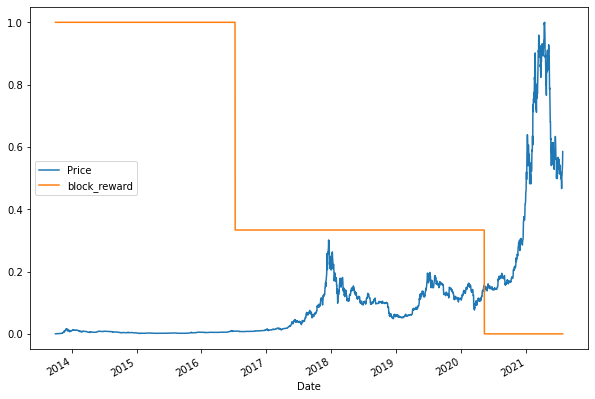

In [ ]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10, 7))

When we scale the block reward and the Bitcoin price, we can see the price goes up as the block reward goes down, perhaps this information will be helpful to our model's performance.

## Making a windowed dataset with pandas

Previously, we used some custom made functions to window our univariate time series.

However, since we've just added another variable to our dataset, these functions won't work.

Since our data is in a pandas DataFrame, we can leverage the `pandas.DataFrame.shift()` method to create a windowed multivariate time series.

The `shift()` method offsets an index by a specified number of periods.

In [ ]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


Now that we've got a windowed dataset, let's separate features `(X)` from labels `(y)`.

Remember in our windowed dataset, we're trying to use the previous `WINDOW_SIZE` steps to predict `HORIZON` steps.

We'll also remove the `NaN` values using pandas `dropna()` method, this equivalent to starting our windowing function at sample 0 (the first sample) + WINDOW_SIZE.

In [ ]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [ ]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2279, 2279, 570, 570)

## Model 6: Dense (multivariate time series)

To keep things simple, let's the `model_1` architecture and use it to train and make predictions on our multivariate time series data.

By replicating the `model_1` architecture we'll be able to see whether or not adding the block reward feature improves or detracts from model performance.

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
18/18 [==============================] - 1s 47ms/step - loss: 1249.5315 - val_loss: 2422.1577
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 327.9118 - val_loss: 2195.4797
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 232.5188 - val_loss: 1424.7205
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 199.5303 - val_loss: 1317.7743
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 191.8783 - val_loss: 1286.8875
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 6/100
18/18 [========================

In [ ]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 693.6093


693.6093139648438

In [ ]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([7227.617 , 7349.5957, 7336.896 , 7701.0347, 8055.8325, 8092.9834,
       7867.3   , 8077.986 , 8096.722 , 8117.6475], dtype=float32)>

In [ ]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 693.6093,
 'mape': 2.7265825,
 'mase': 1.0039599,
 'mse': 1454214.1,
 'rmse': 1205.908}

In [ ]:
# how do these results compare to model_1
model_1_results

{'mae': 693.134,
 'mape': 2.7219105,
 'mase': 1.0032718,
 'mse': 1466880.6,
 'rmse': 1211.1484}

It looks like the adding in the block reward may have helped our model slightly.

## Model 7: N-BEATS algorithm

One of the best ways to improve a model's performance is to increase the number of layers in it.

That's exactly what the [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf) does.

For our next modelling experiment we're going to be replicating the generic architecture of the N-BEATS algorithm (see section 3.3 of the N-BEATS paper).

![figure 1 from N-BBEATS paper, the algorithm we're going to build](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-figure-1-nbeats-paper-annotated.png)


### Building and testing an N-BEATS block layer

In [ ]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast
  

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.19014978  0.83798355 -0.32870018  0.25159916 -0.47540277 -0.77836645
 -0.5299447 ]
Forecast: -0.7554212808609009


### Preparing data for the N-BEATS algorithm using tf.data

To ensure our model training runs as fast as possible, we'll setup our datasets using the tf.data API.

And because the N-BEATS algorithm is focused on univariate time series, we'll start by making training and test windowed datasets of Bitcoin prices (just as we've done above).

In [ ]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [ ]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2279, 2279, 570, 570)

Now let's convert them into TensorFlow `tf.data.Dataset`'s to ensure they run as fast as possible whilst training.

In [ ]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE=1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

### Setting up hyperparameters for N-BEATS algorithm

We'll create variables for each of the hyperparameters we'll be using for our N-BEATS replica. The following hyperparameters are taken from Figure 1 and Table 18/Appendix D of the N-BEATS paper.

In [ ]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = WINDOW_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Hyperparameters ready, now before we create the N-BEATS model, there are two layers to go through which play a large roll in the architecture.

They're what make N-BEATS double residual stacking (section 3.2 of the N-BEATS paper) possible:


*   `tf.keras.layers.subtract(inputs)` - subtracts list of input tensors from each other
*   `tf.keras.layers.add(inputs)` - adds list of input tensors to each other



In [ ]:
# Let's try them out

# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
n_beats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                  theta_size=THETA_SIZE,
                                  horizon=HORIZON,
                                  n_neurons=N_NEURONS,
                                  n_layers=N_LAYERS,
                                  name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
residuals, forecast = n_beats_block_layer(stack_input)

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                  theta_size=THETA_SIZE,
                                  horizon=HORIZON,
                                  n_neurons=N_NEURONS,
                                  n_layers=N_LAYERS,
                                  name=f"NBeatsBlock_{i}")(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"substract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])  

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(patience=100, verbose=1)])


Epoch 00538: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00638: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 2min 16s, sys: 9.7 s, total: 2min 26s
Wall time: 4min 38s


In [ ]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 46ms/step - loss: 729.6960 - mae: 729.6960 - mse: 1565556.1250


[729.6959838867188, 729.6959838867188, 1565556.125]

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([7204.837 , 7310.3184, 7372.4067, 7620.423 , 8003.023 , 8138.344 ,
       7931.6177, 8052.6855, 8097.2065, 8158.3384], dtype=float32)>

In [ ]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 729.696,
 'mape': 2.898682,
 'mase': 1.0561932,
 'mse': 1565556.1,
 'rmse': 1251.2218}

Even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as model_1 or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

### Plotting the N-BEATS architecture we've created

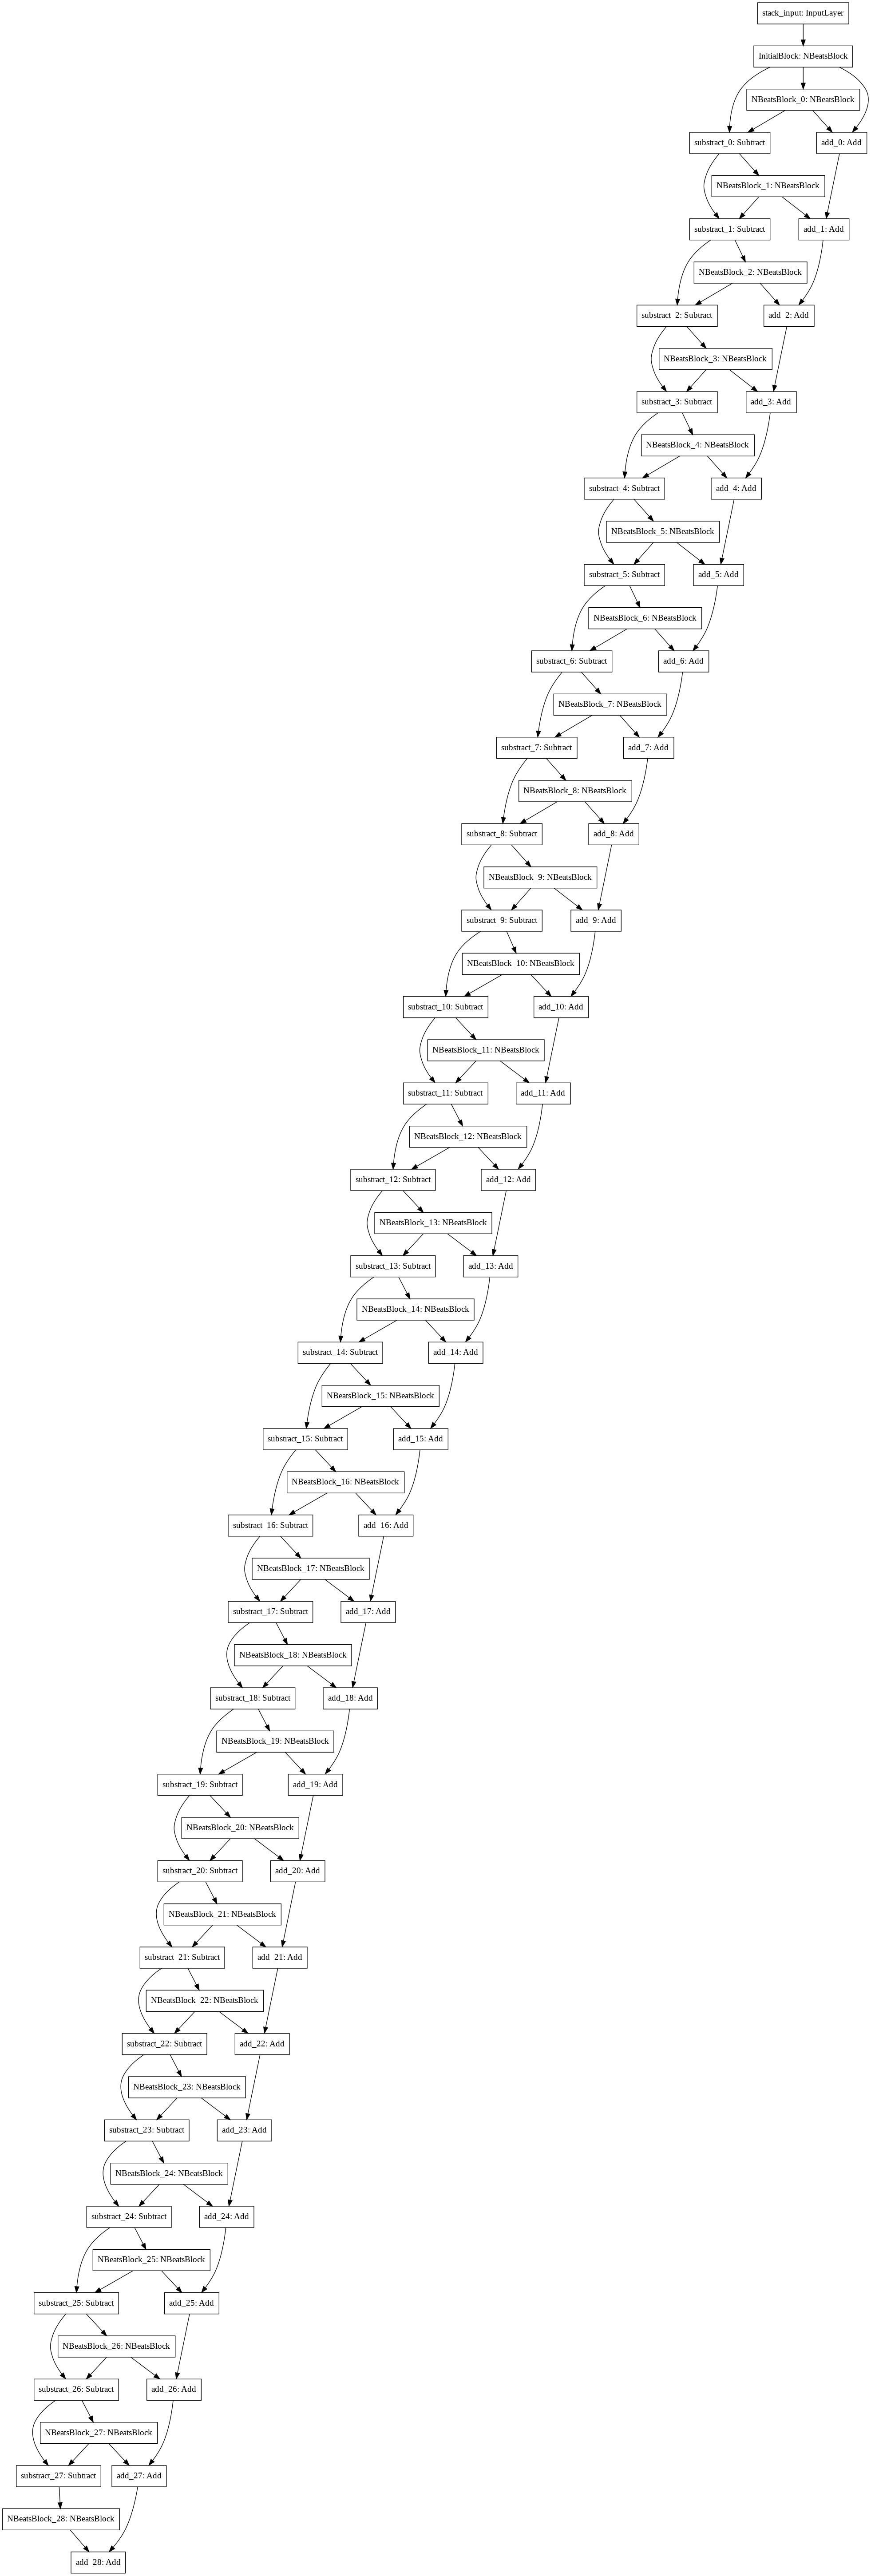

In [ ]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [ ]:
# This will error out unless a "get_config()" method is implemented
model_7.save("/content/drive/MyDrive/BitPredict/model_7_N-BEATS")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/BitPredict/model_7_N-BEATS/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/BitPredict/model_7_N-BEATS/assets


If we would like to save and load the N-BEATS model or any other custom or subclassed layer/model configuration, we should overwrite the get_config() and optionally from_config() methods

## Model 8: Creating an ensemble (stacking different models together)

### Constructing and fitting an ensemble of models (using different loss functions)

In [ ]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        # layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

Let's try it out by running num_iter=5 runs for 1000 epochs. This will result in 15 total models (5 for each different loss function).

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 00908: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 00720: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00820: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 00717: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00817: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 00905: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 00826: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00926: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizi

### Making predictions with an ensemble model

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)

ensemble_preds

<tf.Tensor: shape=(15, 570), dtype=float32, numpy=
array([[ 7285.6626,  7316.916 ,  7342.6196, ..., 33104.    , 34112.17  ,
        34874.914 ],
       [ 7285.633 ,  7285.2354,  7333.15  , ..., 33133.31  , 33878.8   ,
        34672.11  ],
       [ 7253.141 ,  7354.571 ,  7338.4263, ..., 32972.63  , 34196.41  ,
        34687.66  ],
       ...,
       [ 7299.3193,  7324.5396,  7387.375 , ..., 33377.97  , 33943.773 ,
        34684.64  ],
       [ 7241.0693,  7313.4355,  7330.5405, ..., 33228.98  , 34048.164 ,
        34739.81  ],
       [ 7290.6733,  7334.2285,  7375.977 , ..., 33304.945 , 34235.69  ,
        34711.53  ]], dtype=float32)>

In [ ]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results                                  

{'mae': 689.9798,
 'mape': 2.7343082,
 'mase': 0.99870634,
 'mse': 1450817.0,
 'rmse': 1204.4987}

Nice! Looks like the ensemble model is the best performing model on the MAE metric so far.

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

In [ ]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

lower, upper = get_upper_lower(ensemble_preds)

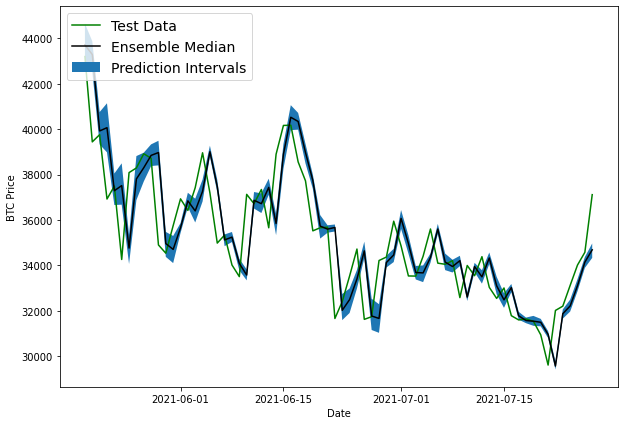

In [ ]:
# let's plot them against our ensemble model's predictions

# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# use matplotlib.pyplot.fill_between() method to shade in the space between the upper and lower bounds.
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

What can you tell about the ensemble model from the plot above?

It looks like the ensemble predictions are lagging slightly behind the actual data.

And the prediction intervals are fairly low throughout.

The combination of lagging predictions as well as low prediction intervals indicates that our ensemble model may be overfitting the data, meaning it's basically replicating what a naïve model would do and just predicting the previous timestep value for the next value.

This would explain why previous attempts to beat the naïve forecast have been futile.

We can test this hypothesis of overfitting by creating a model to make predictions into the future and seeing what they look like.

## Model 9: Train a model on the full historical data to make predictions into future

Let's get some data ready.

In [ ]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [ ]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

### Make predictions on the future

In [ ]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-window_size:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n{last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_forecast)[-window_size:]

  return future_forecast

In [ ]:
# Make forecasts into future of the price of Bitcoin
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE)

Predicting on: 
[29608.59725347 32014.43603389 32203.3656377  33117.75146222
 34014.618359   34574.67066093 37114.29662368] -> Prediction: 29710.63671875

Predicting on: 
[32014.43603389 32203.3656377  33117.75146222 34014.618359
 34574.67066093 37114.29662368 29710.63671875] -> Prediction: 32270.40234375

Predicting on: 
[33117.75146222 34014.618359   34574.67066093 37114.29662368
 29710.63671875 29710.63671875 32270.40234375] -> Prediction: 33238.26171875

Predicting on: 
[37114.29662368 29710.63671875 29710.63671875 32270.40234375
 29710.63671875 32270.40234375 33238.26171875] -> Prediction: 36630.8359375

Predicting on: 
[29710.63671875 32270.40234375 33238.26171875 29710.63671875
 32270.40234375 33238.26171875 36630.8359375 ] -> Prediction: 29997.060546875

Predicting on: 
[33238.26171875 36630.8359375  29710.63671875 32270.40234375
 33238.26171875 36630.8359375  29997.06054688] -> Prediction: 33697.28515625

Predicting on: 
[29997.06054688 29710.63671875 32270.40234375 33238.2617

In [ ]:
future_forecast

[29710.637,
 32270.402,
 33238.26,
 36630.836,
 29997.06,
 33697.285,
 29601.053,
 29914.266,
 32867.906,
 33452.227,
 36324.434,
 30316.219,
 33705.27,
 29373.062]

### Plot future forecasts

In [ ]:
# Create a function to return a date range from some specified start date 
# to a specified number of days into the future (INTO_FUTURE)
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D")  # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

In [ ]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-07-27 00:00:00')

In [ ]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-07-28', '2021-07-29', '2021-07-30', '2021-07-31',
       '2021-08-01', '2021-08-02', '2021-08-03', '2021-08-04',
       '2021-08-05', '2021-08-06', '2021-08-07', '2021-08-08',
       '2021-08-09', '2021-08-10'], dtype='datetime64[D]')

In [ ]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-07-27', '2021-07-27', '2021-07-28', '2021-07-29',
        '2021-07-30', '2021-07-31', '2021-08-01', '2021-08-02',
        '2021-08-03', '2021-08-04', '2021-08-05', '2021-08-06',
        '2021-08-07', '2021-08-08', '2021-08-09', '2021-08-10'],
       dtype='datetime64[D]'),
 array([37114.297, 37114.297, 29710.637, 32270.402, 33238.26 , 36630.836,
        29997.06 , 33697.285, 29601.053, 29914.266, 32867.906, 33452.227,
        36324.434, 30316.219, 33705.27 , 29373.062], dtype=float32))

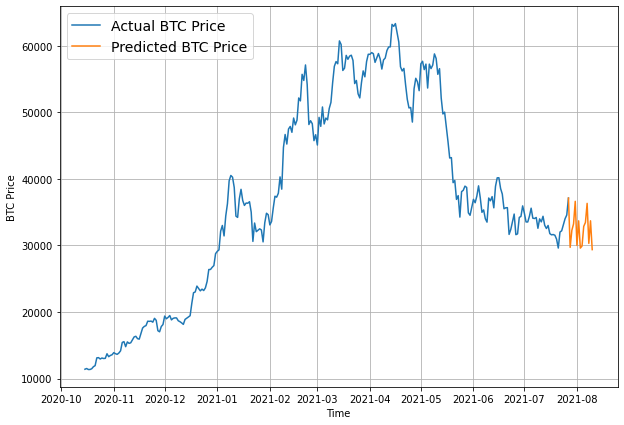

In [ ]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2570, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

It looks like our predictions are starting to form a bit of a cyclic pattern (up and down in the same way).

Perhaps that's due to our model overfitting the training data and not generalizing well for future data. Also, as you could imagine, the further you predict into the future, the higher your chance for error (try seeing what happens when you predict 100 days into the future).

## Model 10: Why forecasting is BS (the turkey problem)

When creating any kind of forecast, you must keep the turkey problem in mind.

The turkey problem is an analogy for when your observational data (your historical data) fails to capture a future event which is catostrophic and could lead you to ruin.

In [ ]:
# Let's introduce a Turkey problem to our BTC data (price BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
btc_price_turkey[-10:]

[31640.9181268351,
 31537.8051899688,
 30940.287284016,
 29608.5972534683,
 32014.4360338924,
 32203.365637698,
 33117.7514622222,
 34014.618359001,
 34574.6706609269,
 371.14296623684]

In [ ]:
# Get the timesteps for the turkey problem 
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-07-18T00:00:00.000000000', '2021-07-19T00:00:00.000000000',
       '2021-07-20T00:00:00.000000000', '2021-07-21T00:00:00.000000000',
       '2021-07-22T00:00:00.000000000', '2021-07-23T00:00:00.000000000',
       '2021-07-24T00:00:00.000000000', '2021-07-25T00:00:00.000000000',
       '2021-07-26T00:00:00.000000000', '2021-07-27T00:00:00.000000000'],
      dtype='datetime64[ns]')

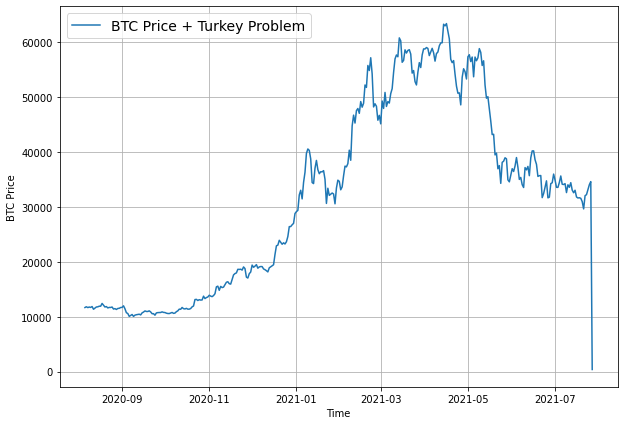

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey, 
                 values=btc_price_turkey, 
                 format="-", 
                 label="BTC Price + Turkey Problem", 
                 start=2500)

In [ ]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

Window step:
 [[0 1 2 3 4 5 6 7]]
Window indexes:
 (<tf.Tensor: shape=(3, 8), dtype=int64, numpy=
array([[0, 1, 2, 3, 4, 5, 6, 7],
       [1, 2, 3, 4, 5, 6, 7, 8],
       [2, 3, 4, 5, 6, 7, 8, 9]])>, <tf.Tensor: shape=(3, 8), dtype=int64, numpy=
array([[2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853],
       [2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854],
       [2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855]])>, TensorShape([2849, 8]))


(2279, 570, 2279, 570)

### Building a turkey model (model to predict on turkey data)

In [ ]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [ ]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 863.1136


863.1135864257812

In [ ]:
# Load best model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 742.7454


742.745361328125

In [ ]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([7263.327 , 7355.1587, 7372.1875, 7705.172 , 8050.483 , 8136.952 ,
       7876.998 , 8081.0376, 8129.1836, 8182.3994], dtype=float32)>

In [ ]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 18570.129,
 'mape': 125.8524,
 'mase': 24.87554,
 'mse': 609324100.0,
 'rmse': 23981.518}

And with just one value change, our error metrics go through the roof.

To make sure, let's remind ourselves of how `model_1` went on unmodified Bitcoin data (no turkey problem).

In [ ]:
model_1_results

{'mae': 693.134,
 'mape': 2.7219105,
 'mase': 1.0032718,
 'mse': 1466880.6,
 'rmse': 1211.1484}

By changing just one value, the `turkey_model` MAE increases almost 30x over `model_1`.

Finally, we'll visualize the turkey predictions over the test turkey data.

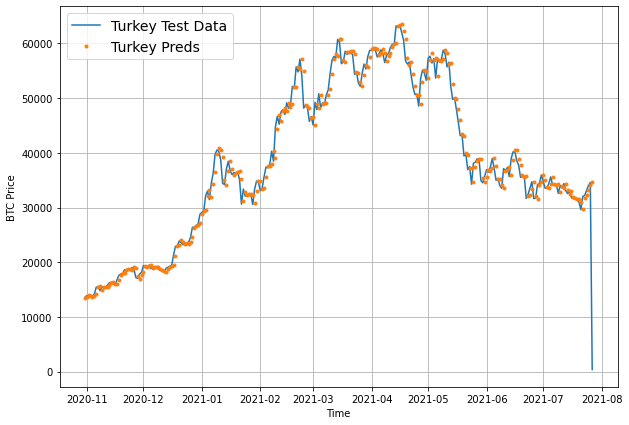

In [ ]:
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=btc_timesteps_turkey[:split_size], values=btc_price_turkey[:split_size], label="Train Data")
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):], 
                 values=btc_price_turkey[-len(y_test):], 
                 format="-", 
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds, 
                 label="Turkey Preds", 
                 start=offset);

## Compare Models

We've trained a bunch of models.

And if anything, we've seen just how poorly machine learning and deep learning models are at forecasting the price of Bitcoin (or any kind of open market value).

To highlight this, let's compare the results of all of the modelling experiments we've performed so far.

In [ ]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,689.122864,1.442620e+06,1201.091064,2.688548,0.999101
model_1_dense_w7_h1,693.133972,1.466881e+06,1211.148438,2.721910,1.003272
model_2_dense_w30_h1,735.764771,1.579209e+06,1256.665894,2.895423,1.059458
model_3_dense_w30_h7,1515.732056,6.989426e+06,1735.868408,5.898083,2.195718
model_4_CONV1D,697.692078,1.478874e+06,1216.089478,2.740438,1.009869
model_5_LSTM,723.764648,1.544826e+06,1242.910034,2.852857,1.047608
model_6_multivariate,693.609314,1.454214e+06,1205.907959,2.726583,1.003960
model_8_NBEATs,729.695984,1.565556e+06,1251.221802,2.898682,1.056193
model_9_ensemble,689.979797,1.450817e+06,1204.498657,2.734308,0.998706
model_10_turkey,18570.128906,6.093241e+08,23981.517578,125.852402,24.875540


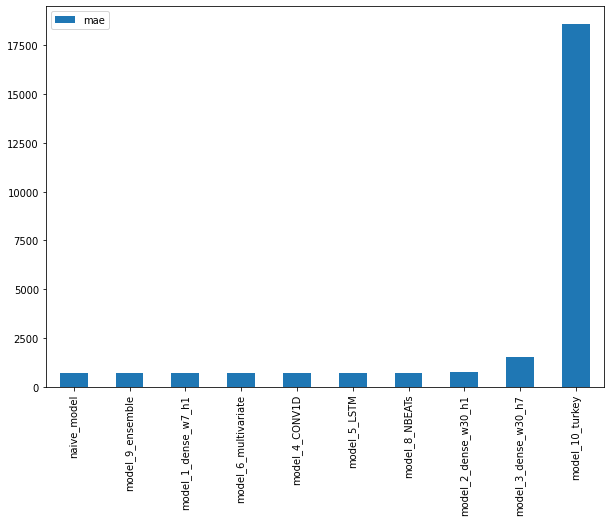

In [ ]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

All of our deep learning models perform worst or on par than the naive model. And for the turkey model, changing a single data point destroys its performance.

## Model_11 Facebook's Kats library

Try out one of the extra algorithm in the modelling experiments part such as [Facebook's Kats library](https://github.com/facebookresearch/Kats)

In [ ]:
pip install kats

In [ ]:
# Parse dates and set date column to index
df = pd.read_csv("/content/drive/MyDrive/BitPredict/BTC_USD_2013-10-01_2021-07-27-CoinDesk.csv", 
                 parse_dates=["Date"])
bitcoin_df = df[["Date", "Closing Price (USD)"]].rename(columns={"Closing Price (USD)" : "Price"})
bitcoin_df.head()

,Date,Price
0,2013-10-01,123.65499
1,2013-10-02,125.45500
2,2013-10-03,108.58483
3,2013-10-04,118.67466
4,2013-10-05,121.33866


In [ ]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2856 entries, 0 to 2855
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2856 non-null   datetime64[ns]
 1   Price   2856 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 44.8 KB


In [ ]:
# Using Prophet model to forecast https://github.com/facebookresearch/Kats

from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams

# convert to TimeSeriesData object
bitcoin_prices_ts = TimeSeriesData(bitcoin_df, time_col_name="Date")

# create a model param instance
params = ProphetParams(daily_seasonality=True) # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(bitcoin_prices_ts, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 14 month
fcst = m.predict(steps=14, freq="D")

In [ ]:
len(fcst)

14

In [ ]:
fcst.head()

,time,fcst,fcst_lower,fcst_upper
0,2021-07-28,43940.297221,38239.776758,49481.033342
1,2021-07-29,44129.118736,38195.564273,50633.988084
2,2021-07-30,44260.061472,38640.281931,50545.908411
3,2021-07-31,44425.207988,38368.860982,50449.855593
4,2021-08-01,44586.739234,38584.365786,50397.854310


In [ ]:
# Make column "time" as index
preds = fcst.set_index('time')
preds.head()

,fcst,fcst_lower,fcst_upper
time,,,
2021-07-28,43940.297221,38239.776758,49481.033342
2021-07-29,44129.118736,38195.564273,50633.988084
2021-07-30,44260.061472,38640.281931,50545.908411
2021-07-31,44425.207988,38368.860982,50449.855593
2021-08-01,44586.739234,38584.365786,50397.854310


In [ ]:
current_preds = preds["fcst"]
lower_preds = preds["fcst_lower"]
upper_preds = preds["fcst_upper"]

In [ ]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(current_preds.index, 0, last_timestep)
future_forecast = np.insert(current_preds.values, 0, btc_price[-1])
next_time_steps, future_forecast

(DatetimeIndex(['2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
                '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
                '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
                '2021-08-08', '2021-08-09', '2021-08-10'],
               dtype='datetime64[ns]', name='time', freq=None),
 array([37114.29662368, 43940.2972213 , 44129.11873576, 44260.06147167,
        44425.20798839, 44586.73923378, 44718.52061749, 44879.70960791,
        45037.94326545, 45203.79814315, 45306.44752662, 45438.43203833,
        45562.45123096, 45652.94160157, 45769.67538751]))

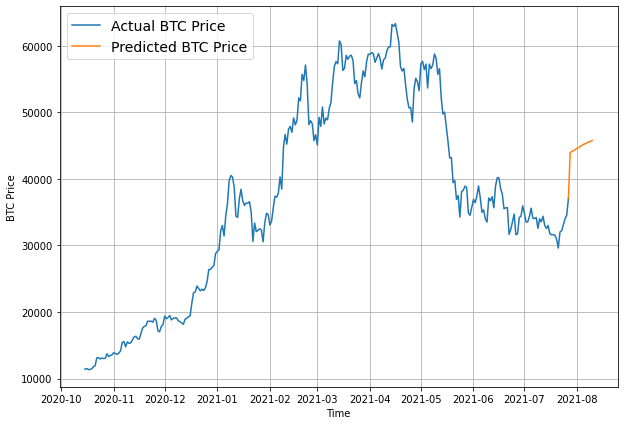

In [ ]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2570, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

Looks good and almost like real! But I think it's just lucky! :)

But the predictions are very smoothed, which distinguishes this model from others.